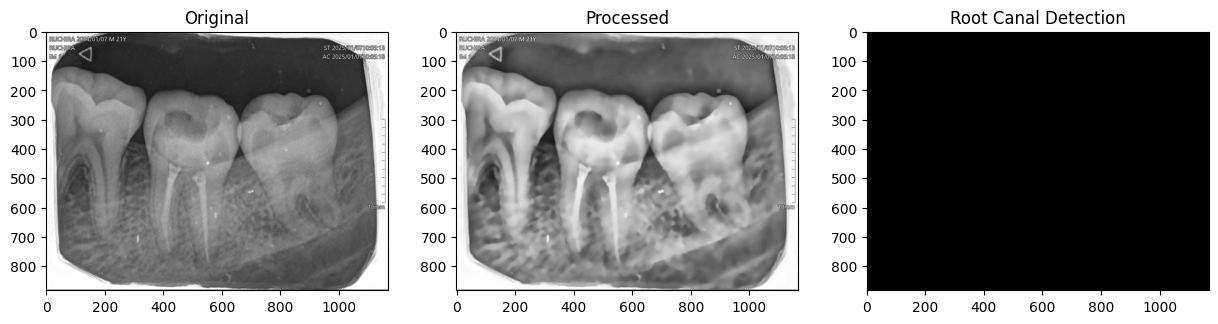

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, filters, morphology

def preprocess_image(img_path):
    # Read image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize for consistency (optional)
    #img = cv2.resize(img, (512, 512))
    
    # Denoising with Non-Local Means
    denoised = cv2.fastNlMeansDenoising(img, h=15, templateWindowSize=7, searchWindowSize=21)
    
    # Contrast enhancement using CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(denoised)
    
    # Adaptive gamma correction
    gamma_corrected = exposure.adjust_gamma(enhanced, gamma=0.7)
    
    return gamma_corrected

def detect_root_canal(img):
    # Multi-scale edge enhancement
    blur1 = cv2.GaussianBlur(img, (5,5), 0)
    blur2 = cv2.GaussianBlur(img, (9,9), 0)
    edges = blur1 - blur2
    edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX)
    
    # Adaptive thresholding with hysteresis
    thresh_low = filters.threshold_otsu(edges) * 0.5
    thresh_high = filters.threshold_otsu(edges) * 1.5
    edge_mask = np.zeros_like(edges)
    edge_mask[(edges >= thresh_low) & (edges <= thresh_high)] = 255
    
    # Morphological reconstruction
    kernel = morphology.disk(2)
    opened = morphology.opening(edge_mask, kernel)
    closed = morphology.closing(opened, morphology.disk(3))
    
    # Region analysis
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Shape-based filtering for root canals
    canal_mask = np.zeros_like(img)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        x,y,w,h = cv2.boundingRect(cnt)
        aspect_ratio = w/h if h != 0 else 0
        solidity = area/(w*h) if w*h !=0 else 0
        
        # Root canal characteristics (tune these parameters)
        if (area > 50) and (aspect_ratio > 3 or aspect_ratio < 0.33) and (solidity < 0.5):
            cv2.drawContours(canal_mask, [cnt], -1, 255, -1)
    
    # Final refinement
    final_mask = cv2.medianBlur(canal_mask, 5)
    return final_mask

def visualize_results(original, processed, mask):
    plt.figure(figsize=(15,5))
    plt.subplot(131), plt.imshow(original, cmap='gray'), plt.title('Original')
    plt.subplot(132), plt.imshow(processed, cmap='gray'), plt.title('Processed')
    plt.subplot(133), plt.imshow(mask, cmap='gray'), plt.title('Root Canal Detection')
    plt.show()

# Main pipeline
img_path = "195-ruchira.jpg"
original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
preprocessed = preprocess_image(img_path)
canal_mask = detect_root_canal(preprocessed)
visualize_results(original, preprocessed, canal_mask)

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, filters, morphology
import tensorflow as tf  # For deep learning component
from tensorflow.keras.models import load_model

# --------------------------
# Enhanced Hybrid Pipeline
# --------------------------

def hybrid_preprocessing(img_path):
    """Combined traditional and learning-based preprocessing"""
    # Read image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Augmentation (enable during training)
    if False:  # Set to True during model training
        img = cv2.flip(img, 1)
    
    # Multi-stage Enhancement
    denoised = cv2.fastNlMeansDenoising(img, h=20, templateWindowSize=9, searchWindowSize=21)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(10,10))
    enhanced = clahe.apply(denoised)
    
    # Deep Learning-based Enhancement (placeholder)
    dl_enhanced = tf.keras.applications.efficientnet.preprocess_input(
        cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)
    )
    
    return enhanced, dl_enhanced

def traditional_detection(img):
    """Improved traditional pipeline with morphological constraints"""
    # Multi-scale Hessian enhancement
    blurred = cv2.GaussianBlur(img, (0,0), 3)
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=5)
    gradient_mag = np.sqrt(sobelx**2 + sobely**2)
    
    # Adaptive thresholding
    thresh = filters.threshold_multiotsu(gradient_mag, classes=3)
    regions = np.digitize(gradient_mag, bins=thresh)
    
    # Morphological reconstruction
    canal_mask = np.zeros_like(img)
    canal_mask[regions == 2] = 255  # Select highest gradient class
    
    # Anatomical constraints
    kernel = morphology.disk(3)
    opened = morphology.opening(canal_mask, kernel)
    closed = morphology.closing(opened, kernel)
    
    return closed

def deep_learning_detection(img):
    """Integrated deep learning component (replace with your trained model)"""
    # Load pretrained model (placeholder - replace with your actual model)
    # model = load_model('canal_detector.h5')
    # pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
    
    # Temporary dummy model
    pred_mask = cv2.adaptiveThreshold(
        img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 5
    )
    return pred_mask

def hybrid_fusion(traditional_mask, dl_mask):
    """Fusion of traditional and DL results"""
    # Confidence-based fusion
    combined = cv2.bitwise_or(traditional_mask, dl_mask)
    
    # Morphological refinement
    kernel = morphology.star(3)
    refined = morphology.closing(combined, kernel)
    return refined

# --------------------------
# Visualization & Pipeline
# --------------------------

def visualize_hybrid_results(original, enhanced, trad_mask, dl_mask, final_mask):
    plt.figure(figsize=(20,10))
    
    plt.subplot(231), plt.imshow(original, cmap='gray'), plt.title('Original Image')
    plt.subplot(232), plt.imshow(enhanced, cmap='gray'), plt.title('Enhanced Image')
    plt.subplot(233), plt.imshow(trad_mask, cmap='gray'), plt.title('Traditional Detection')
    plt.subplot(234), plt.imshow(dl_mask, cmap='gray'), plt.title('Deep Learning Detection')
    plt.subplot(235), plt.imshow(final_mask, cmap='gray'), plt.title('Fused Result')
    
    plt.tight_layout()
    plt.show()

# Main Hybrid Pipeline
def main(img_path):
    # 1. Hybrid Preprocessing
    enhanced, dl_ready = hybrid_preprocessing(img_path)
    
    # 2. Traditional Detection
    trad_mask = traditional_detection(enhanced)
    
    # 3. Deep Learning Detection
    dl_mask = deep_learning_detection(dl_ready)
    
    # 4. Result Fusion
    final_mask = hybrid_fusion(trad_mask, dl_mask)
    
    # Visualization
    original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    visualize_hybrid_results(original, enhanced, trad_mask, dl_mask, final_mask)
    
    return final_mask

# Execute pipeline
if __name__ == "__main__":
    result_mask = main("195-ruchira.jpg")

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def is_contour_inside(contour, mask):
    """
    Check if every point of the contour lies within the white area of the mask.
    Returns True if all contour points are inside (mask pixel value 255).
    """
    for pt in contour:
        x, y = pt[0]
        if mask[y, x] == 0:
            return False
    return True

# --- Step 1: Load and Enhance the Image ---
image_path = '5900-kasun.jpg'  # Replace with your image path
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise IOError("Image not found!")

# Apply CLAHE for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_enhanced = clahe.apply(img)

# --- Step 2: Detect the Tooth Boundary ---
# Use Otsu's thresholding to segment the bright tooth region from the background.
# Since the tooth is generally brighter than the background, Otsu works well.
_, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Fill in small gaps using morphological closing
kernel = np.ones((5, 5), np.uint8)
thresh_closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# Find contours in the thresholded image. We assume the tooth is the largest bright region.
contours, _ = cv2.findContours(thresh_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if not contours:
    raise ValueError("No contours found!")
tooth_contour = max(contours, key=cv2.contourArea)

# Create a binary mask for the tooth using the largest contour.
tooth_mask = np.zeros_like(img)
cv2.drawContours(tooth_mask, [tooth_contour], -1, 255, thickness=-1)

# Extract the tooth region from the enhanced image.
tooth_region = cv2.bitwise_and(img, img, mask=tooth_mask)

# --- Step 3: Detect Bright Areas (Root Fillings) Within the Tooth ---
# Since fillings are bright, we threshold for high intensity values.
# Adjust the bright_threshold value based on your image characteristics.
bright_threshold = 180  # Example value; tweak as needed.
_, bright_regions = cv2.threshold(tooth_region, bright_threshold, 255, cv2.THRESH_BINARY)

# Make sure we only consider bright areas within the tooth region.
bright_regions = cv2.bitwise_and(bright_regions, bright_regions, mask=tooth_mask)

# Optionally, clean up noise using morphological opening.
bright_regions_clean = cv2.morphologyEx(bright_regions, cv2.MORPH_OPEN, kernel)

# Find contours in the bright regions.
bright_contours, _ = cv2.findContours(bright_regions_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours that are completely within the tooth and meet a minimum area criterion.
filling_candidates = []
min_area = 20  # Adjust the minimum area based on expected filling size.
for cnt in bright_contours:
    if is_contour_inside(cnt, tooth_mask):
        area = cv2.contourArea(cnt)
        if area > min_area:
            filling_candidates.append(cnt)

# --- Step 4: Visualization ---
# Convert the original image to BGR for colored visualization.
output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Draw the tooth boundary in green.
cv2.drawContours(output_img, [tooth_contour], -1, (0, 255, 0), 2)
# Draw the candidate filling areas in red.
cv2.drawContours(output_img, filling_candidates, -1, (0, 0, 255), 2)

# Display the results using matplotlib.
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.title("Original Image")
plt.imshow(img, cmap='gray')
plt.axis("off")

plt.subplot(2, 3, 2)
plt.title("Enhanced Image (CLAHE)")
plt.imshow(img_enhanced, cmap='gray')
plt.axis("off")

plt.subplot(2, 3, 3)
plt.title("Tooth Mask")
plt.imshow(tooth_mask, cmap='gray')
plt.axis("off")

plt.subplot(2, 3, 4)
plt.title("Bright Regions (Pre-Cleaning)")
plt.imshow(bright_regions, cmap='gray')
plt.axis("off")

plt.subplot(2, 3, 5)
plt.title("Bright Regions (Cleaned)")
plt.imshow(bright_regions_clean, cmap='gray')
plt.axis("off")

plt.subplot(2, 3, 6)
plt.title("Detected Root Fillings")
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()
